2/2 [==============================] - 1s 8ms/step - loss: 1.1002 - accuracy: 0.3500


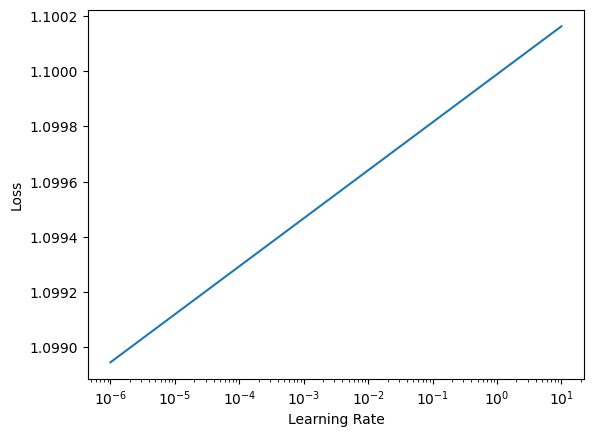

Epoch 1/50
2/2 [==============================] - 1s 299ms/step - loss: 347110336.0000 - accuracy: 0.3594 - val_loss: 276343264.0000 - val_accuracy: 0.1875
Epoch 2/50
2/2 [==============================] - 0s 59ms/step - loss: 221002352.0000 - accuracy: 0.3906 - val_loss: 224727136.0000 - val_accuracy: 0.1875
Epoch 3/50
2/2 [==============================] - 0s 56ms/step - loss: 225125168.0000 - accuracy: 0.3750 - val_loss: 183227632.0000 - val_accuracy: 0.1875
Epoch 4/50
2/2 [==============================] - 0s 60ms/step - loss: 187983344.0000 - accuracy: 0.4375 - val_loss: 146712240.0000 - val_accuracy: 0.1875
Epoch 5/50
2/2 [==============================] - 0s 59ms/step - loss: 139512032.0000 - accuracy: 0.4375 - val_loss: 117347656.0000 - val_accuracy: 0.1875
Epoch 6/50
2/2 [==============================] - 0s 65ms/step - loss: 155222656.0000 - accuracy: 0.3594 - val_loss: 96284520.0000 - val_accuracy: 0.1875
Epoch 7/50
2/2 [==============================] - 0s 73ms/step - loss:

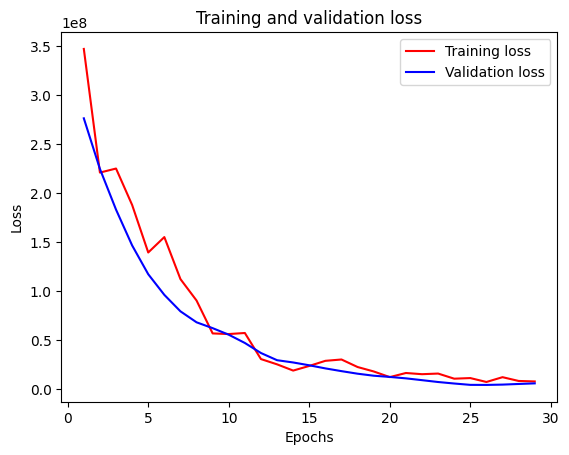

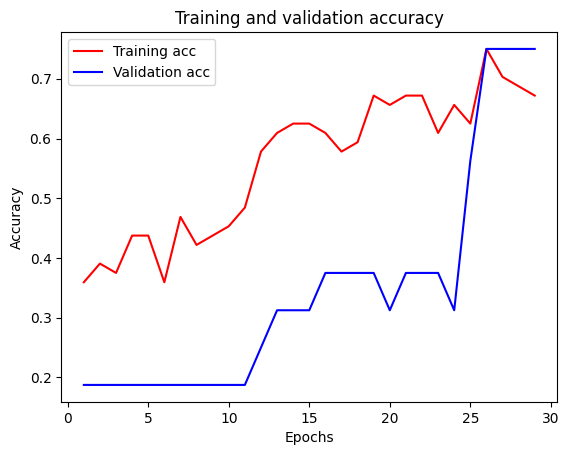

1/1 [==============================] - 0s 39ms/step - loss: 8488574.0000 - accuracy: 0.8000
Accuracy: 0.800000011920929
1/1 [==============================] - 0s 77ms/step
Predicted class: 1
Predicted class: Allamanda Cathartica


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('dataset.csv')

# Shuffle the dataset
shuffled_ds = dataset.sample(frac=1, random_state=42)

# Extract the features and the one-hot encoded target variables
X = dataset.drop(['class_0', 'class_1', 'class_2'], axis=1).values
y = dataset[['class_0', 'class_1', 'class_2']].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model with additional layers
model = Sequential([
    Dense(52, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(44, activation='relu'),
    Dense(36, activation='relu'), 
    Dropout(0.3),                  
    Dense(28, activation='relu'),  
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate finder callback
class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=10, steps_per_epoch=None, epochs=1):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def on_train_begin(self, logs=None):
        K.set_value(self.model.optimizer.lr, self.min_lr)
    
    def on_batch_end(self, batch, logs=None):
        self.iteration += 1
        lr = K.get_value(self.model.optimizer.lr)
        self.history.setdefault('lr', []).append(lr)
        self.history.setdefault('loss', []).append(logs['loss'])
        lr *= (self.max_lr / self.min_lr) ** (1 / self.total_iterations)
        K.set_value(self.model.optimizer.lr, lr)
    
    def plot_loss(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.show()

# Find the optimal learning rate
steps_per_epoch = len(X_train_scaled) // 50
lr_finder = LearningRateFinder(steps_per_epoch=steps_per_epoch)
history = model.fit(X_train_scaled, y_train, epochs=1, batch_size=50, callbacks=[lr_finder])
lr_finder.plot_loss()

# Choose the optimal learning rate (for example, based on the plot)
optimal_lr = 0.056  # Set this based on the plot

# Re-compile the model with the optimal learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with the early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=50, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')

# Function to get user inputs
def get_user_inputs():
    user_input = []
    feature_names = dataset.columns[:-3]  # Exclude the last 3 columns (class_0, class_1, class_2)
    for feature in feature_names:
        value = float(input(f"Enter value for {feature}: "))  # Ensure the input is of correct type
        user_input.append(value)
    return user_input

# Function to predict the class
def predict_class(user_input):
    # Preprocess the user input
    user_input_scaled = scaler.transform(np.array(user_input).reshape(1, -1))
    
    # Make prediction
    predicted_probabilities = model.predict(user_input_scaled)
    predicted_class = np.argmax(predicted_probabilities)
    
    return predicted_class

# Get user inputs
user_input = get_user_inputs()
predicted_class = predict_class(user_input)
print("Predicted class:", predicted_class)

# Display the predicted class and corresponding image
if predicted_class == 1:
    print("Predicted class: Allamanda Cathartica")
    image = Image.open('Golden Trumpet.jpeg')
    image.show()

elif predicted_class == 0:
    print("Predicted class: Ixora coccinea")
    image = Image.open('Ixora.jpeg')
    image.show()

elif predicted_class == 2:
    print("Predicted class: Cryptostegia grandiflora")
    image = Image.open('Cryptostegia grandiflora.jpeg')
    image.show()
else:
    print("Not defined")
